In [67]:
# Autoreload packages that are modified
%load_ext autoreload
%autoreload 2

from datetime import datetime, timedelta
import glob
import os
import sys
import time
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from data import get_data
from utils import plot_forecast, plot_components

cwd = os.getcwd()
sys.path.append(f"{cwd}/forecast_rodeo")
sys.path.append(f"{cwd}/forecast_rodeo/src/experiments")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# https://stackoverflow.com/questions/43147983/could-not-create-cudnn-handle-cudnn-status-internal-error
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Get the data

In [21]:
num_forecast_steps = 7 * 4 # 28 days

X, anoms, clims, temps, dates, \
columnstr_to_index, index_to_columnstr = get_data()

X_train = X[:-num_forecast_steps, :]
anoms_train = anoms[:-num_forecast_steps]
clims_train = clims[:-num_forecast_steps]
temps_train = temps[:-num_forecast_steps]
dates_train = dates[:-num_forecast_steps]

X_test = X[-num_forecast_steps:, :]
anoms_test = anoms[-num_forecast_steps:]
clims_test = clims[-num_forecast_steps:]
temps_test = temps[-num_forecast_steps:]
dates_test = dates[-num_forecast_steps:]

is_predicting_anomaly = True
if is_predicting_anomaly:
    Y_train = anoms_train
    Y_test = anoms_test
    print(f"Y is temperature anomaly!")
else:
    Y_train = temps_train
    Y_test = temps_test
    print(f"Y is temperature directly!")


['forecast_rodeo/results/regression/shared/contest_tmp2m_34w/lat_lon_date_data-contest_tmp2m_34w.h5', 'forecast_rodeo/results/regression/shared/contest_tmp2m_34w/date_data-contest_tmp2m_34w.h5']
lat_oi: 27.0, lon_oi: 261.0


In [23]:
print(clims.shape)

(13283,)


In [4]:
years_in_data = dates.dt.year
first_year = min(years_in_data)
last_year = max(years_in_data)
print(first_year)
print(last_year)

print(index_to_columnstr)

num_forecast_steps = 7 * 4 # 28 days

1982
2018
{0: 'tmp2m_shift29', 1: 'tmp2m_shift29_anom', 2: 'tmp2m_shift58', 3: 'tmp2m_shift58_anom', 4: 'rhum_shift30', 5: 'pres_shift30', 6: 'nmme_wo_ccsm3_nasa', 7: 'nmme0_wo_ccsm3_nasa', 8: 'mei_shift45', 9: 'phase_shift17', 10: 'sst_2010_1_shift30', 11: 'sst_2010_2_shift30', 12: 'sst_2010_3_shift30', 13: 'icec_2010_1_shift30', 14: 'icec_2010_2_shift30', 15: 'icec_2010_3_shift30', 16: 'wind_hgt_10_2010_1_shift30', 17: 'wind_hgt_10_2010_2_shift30'}


(13255,)


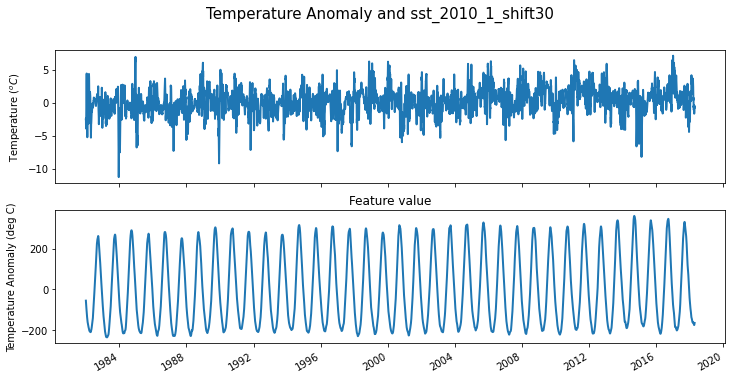

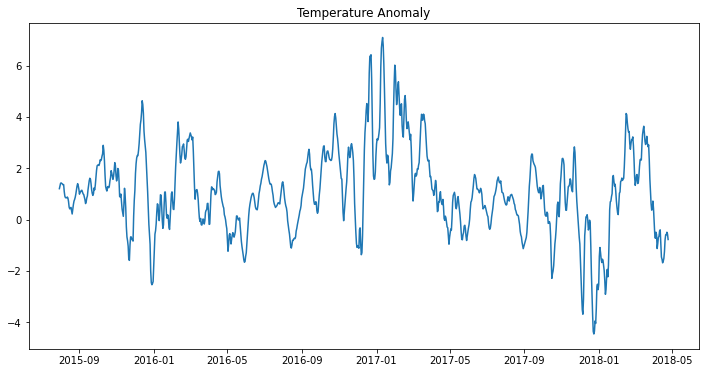

In [35]:
print(Y_train.shape)

colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(dates_train,
        Y_train, lw=2, label="training data")
ax.set_ylabel("Temperature ($^oC$)")

ax = fig.add_subplot(2, 1, 2)

feature_str = "sst_2010_1_shift30"
ax.plot(dates_train,
        X_train[:, columnstr_to_index[feature_str]], lw=2, label="training data")
ax.set_ylabel("Temperature Anomaly (deg C)" if is_predicting_anomaly else "Temperature (deg C)")
ax.set_title("Feature value")
fig.suptitle(f"Temperature Anomaly and {feature_str}" if is_predicting_anomaly else 
             f"Temperature Anomaly and {feature_str}",
             fontsize=15)
fig.autofmt_xdate()

plt.figure(figsize=(12, 6))
plt.title(f"Temperature Anomaly" if is_predicting_anomaly else f"Temperature")
plt.plot(dates_train[-1000:], Y_train[-1000:])


In [36]:
def build_model(observed_time_series):
#     seasonal = tfp.sts.Seasonal(
#         num_seasons=4, 
#         observed_time_series=observed_time_series,
#         num_steps_per_season=91, 
#         name='seasonal'
#     )
    monthly = tfp.sts.Seasonal(
        num_seasons=12,
        observed_time_series=observed_time_series,
        num_steps_per_season=[31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
        drift_scale_prior=tfd.LogNormal(loc=-1., scale=0.1),
        initial_effect_prior=tfd.Normal(loc=0., scale=5.),
        name='month_of_year',
    )
#     features_effect = tfp.sts.LinearRegression(
#         design_matrix=other_features - np.mean(other_features), 
#         name='other_fehthhhhhhhhhhhatures'
#     )   
#     autoregressive = tfp.sts.Autoregressive(
#         order=1,
#         observed_time_series=observed_time_series,
#         name='autoregressive'
#     )
    semilocal = tfp.sts.SemiLocalLinearTrend()
    model = tfp.sts.Sum([
#             seasonal,
        monthly,
#             features_effect,
#             autoregressive
        semilocal

        ],
        observed_time_series=observed_time_series
    )
    return model

temperature_model = build_model(Y_train)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=temperature_model)
print(variational_posteriors)

tfp.distributions.JointDistributionNamed("build_factored_surrogate_posterior_JointDistributionNamed", batch_shape={SemiLocalLinearTrend/_autoregressive_coef: [], SemiLocalLinearTrend/_level_scale: [], SemiLocalLinearTrend/_slope_mean: [], SemiLocalLinearTrend/_slope_scale: [], month_of_year/_drift_scale: [], observation_noise_scale: []}, event_shape={SemiLocalLinearTrend/_autoregressive_coef: [], SemiLocalLinearTrend/_level_scale: [], SemiLocalLinearTrend/_slope_mean: [], SemiLocalLinearTrend/_slope_scale: [], month_of_year/_drift_scale: [], observation_noise_scale: []}, dtype={SemiLocalLinearTrend/_autoregressive_coef: float32, SemiLocalLinearTrend/_level_scale: float32, SemiLocalLinearTrend/_slope_mean: float32, SemiLocalLinearTrend/_slope_scale: float32, month_of_year/_drift_scale: float32, observation_noise_scale: float32})


60
462.0085062980652 seconds


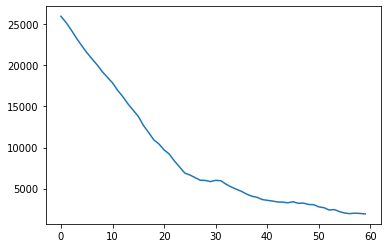

In [37]:
# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 60
print(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)

# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=temperature_model.joint_log_prob(
        observed_time_series=Y_train),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

start = time.time()
elbo_loss_curve = train()
end = time.time()
print(f"{end - start} seconds")
plt.plot(elbo_loss_curve)
plt.show()

In [38]:
# Draw samples from the variational posterior.
q_samples_temperature_ = variational_posteriors.sample(50)


print("Inferred parameters:")
for param in temperature_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_temperature_[param.name], axis=0),
                              np.std(q_samples_temperature_[param.name], axis=0)))


Inferred parameters:
observation_noise_scale: 0.022933004423975945 +- 0.0006100779282860458
month_of_year/_drift_scale: 0.14178499579429626 +- 0.007591776084154844
SemiLocalLinearTrend/_level_scale: 0.1319161355495453 +- 0.002300064079463482
SemiLocalLinearTrend/_slope_mean: 0.013388700783252716 +- 0.009695766493678093
SemiLocalLinearTrend/_slope_scale: 0.20152798295021057 +- 0.0028655468486249447
SemiLocalLinearTrend/_autoregressive_coef: 0.8047537803649902 +- 0.06155052408576012


## Forecasting

In [39]:
start = time.time()
temperature_forecast_dist = tfp.sts.forecast(
    model=temperature_model,
    observed_time_series=Y_train,
    parameter_samples=q_samples_temperature_,
    num_steps_forecast=num_forecast_steps)
end = time.time()
print(f"time elapsed = {end - start}")

time elapsed = 248.68322372436523


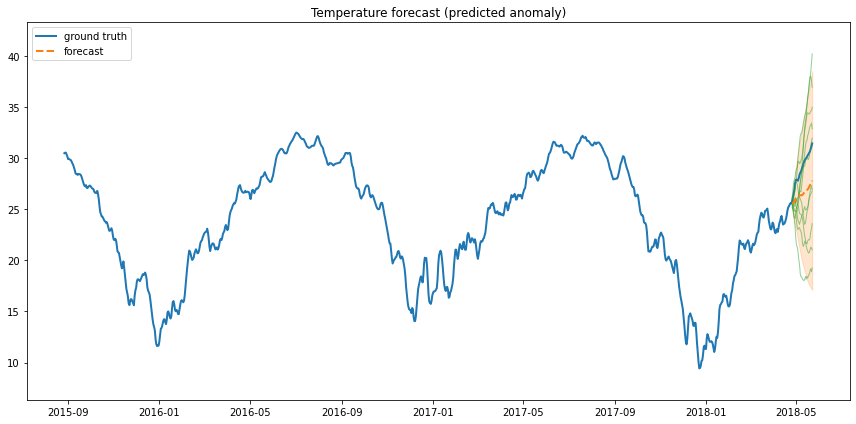

In [71]:
num_samples=10

(
    temperature_forecast_mean,
    temperature_forecast_scale,
    temperature_forecast_samples
) = (
    temperature_forecast_dist.mean().numpy()[..., 0],
    temperature_forecast_dist.stddev().numpy()[..., 0],
    temperature_forecast_dist.sample(num_samples).numpy()[..., 0]
    )

if is_predicting_anomaly:
    fig, ax = plot_forecast(dates, Y + clims,
                            temperature_forecast_mean + clims_test,
                            temperature_forecast_scale,
                            temperature_forecast_samples + clims_test,
                            title="Temperature forecast (predicted anomaly)",
                            plot_num=1000,
    )
else:
    fig, ax = plot_forecast(dates, Y,
                            temperature_forecast_mean,
                            temperature_forecast_scale,
                            temperature_forecast_samples,
                            title="Temperature forecast (predicted direct value)",
                            plot_num=1000,
    )

fig.tight_layout()


In [47]:
# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = tfp.sts.decompose_by_component(
    temperature_model,
    observed_time_series=Y_train,
    parameter_samples=q_samples_temperature_
)

forecast_component_dists = tfp.sts.decompose_forecast_by_component(
    temperature_model,
    forecast_dist=temperature_forecast_dist,
    parameter_samples=q_samples_temperature_
)


temperature_component_means_, temperature_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)

temperature_forecast_component_means_, temperature_forecast_component_stddevs_ = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
)


NameError: name 'collections' is not defined

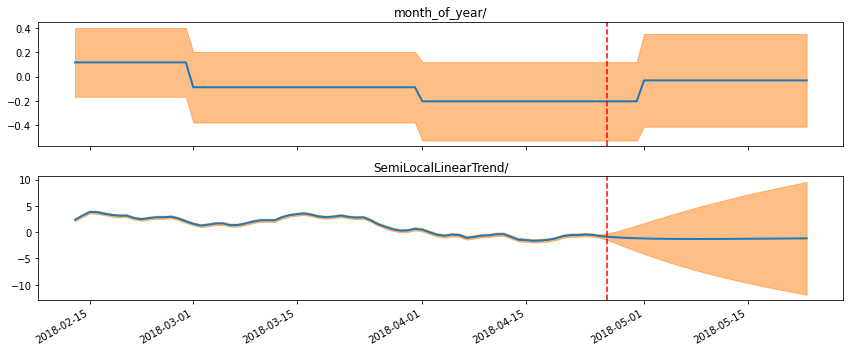

In [70]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
    
for k in temperature_component_means_.keys():
    component_with_forecast_means_[k] = np.concatenate([
        temperature_component_means_[k],
        temperature_forecast_component_means_[k]
    ], axis=-1)
    component_with_forecast_stddevs_[k] = np.concatenate([
        temperature_component_stddevs_[k],
        temperature_forecast_component_stddevs_[k]
    ], axis=-1)

fig, axes = plot_components(
    dates,
    component_with_forecast_means_,
    component_with_forecast_stddevs_,
    vals_to_plot = 100
)
for ax in axes.values():
  ax.axvline(dates.to_numpy()[-num_forecast_steps], linestyle="--", color='red')
